# Image classification model

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
from efficientnet.tfkeras import EfficientNetB0 as Net #Use pre-trained model for fine tuning
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input

### Set some hyperparameters

In [2]:
batch_size = 48
width = 150
height = 150
epochs = 20
NUM_TRAIN = 2000
NUM_TEST = 1000
dropout_rate = 0.2
input_shape = (height, width, 3)

### Divide data in train, validate, and test

In [6]:
original_dataset_dir = '../model-data/cats_and_dogs/PetImages'

cat_images = glob.glob(os.path.join(original_dataset_dir, "Cat", '*.jpg'))
dog_images = glob.glob(os.path.join(original_dataset_dir, "Dog", '*.jpg'))

In [3]:
base_dir = '../model-data/dog_vs_cat_small'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [4]:
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

# Directory with our test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

In [7]:
# Copy first NUM_TRAIN//2 cat images to train_cats_dir
fnames = cat_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST//2]
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST//2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [8]:
# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [9]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


### Transfer learning

In [10]:
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

In [11]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [13]:
conv_base.trainable = False #use model as is

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

#Note: pillow was downgraded to version 4.0.0 when running this cell to avoid Warning
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
41/41 [==============================] - 45s 1s/step - loss: 1.6394 - acc: 0.5733 - val_loss: 1.1153 - val_acc: 0.6250
Epoch 2/20
41/41 [==============================] - 44s 1s/step - loss: 1.3056 - acc: 0.6235 - val_loss: 0.9419 - val_acc: 0.6750
Epoch 3/20
41/41 [==============================] - 43s 1s/step - loss: 1.2439 - acc: 0.6173 - val_loss: 0.8266 - val_acc: 0.7115
Epoch 4/20
41/41 [==============================] - 44s 1s/step - loss: 1.1403 - acc: 0.6583 - val_loss: 0.7485 - val_acc: 0.7396
Epoch 5/20
41/41 [==============================] - 43s 1s/step - loss: 1.0931 - acc: 0.6742 - val_loss: 0.6839 - val_acc: 0.7708
Epoch 6/20
41/41 [==============================] - 43s 1s/step - loss: 1.0059 - acc: 0.6977 - val_loss: 0.6155 - val_acc: 0.8000
Epoch 7/20
41/41 [==============================] - 43s 1s/step - loss: 0.9480 - acc: 0.7065 - val_loss: 0.5734 - val_acc: 0.8125
Epoch 8/20
41/

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

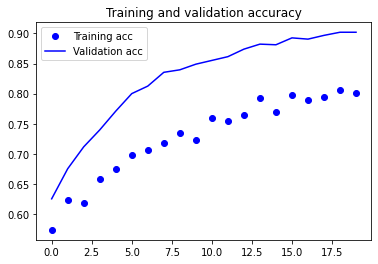

In [17]:
plt.plot(acc, 'bo', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

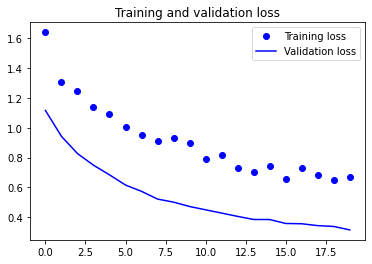

In [18]:
plt.plot(loss, 'bo', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Test a prediction

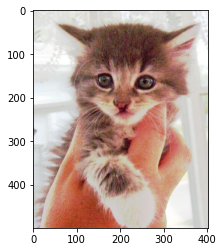

In [19]:
image = imread('../model-data/cats_and_dogs/PetImages/Cat/100.jpg')
plt.imshow(image)
plt.show()

In [23]:
img = keras_image.load_img('../model-data/cats_and_dogs/PetImages/Cat/100.jpg', target_size=(height, width))
x = keras_image.img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255.
result = model.predict([x])[0]
print(result)

[9.9994898e-01 5.1076386e-05]


### Save model

In [24]:
model.save("trained-model.h5")